In [20]:
from warnings import simplefilter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sysidentpy.model_structure_selection import FROLS
from sysidentpy.model_structure_selection import AOLS
from sysidentpy.model_structure_selection import MetaMSS
from sysidentpy.basis_function import Polynomial
from sysidentpy.utils.plotting import plot_results
from torch import nn
# from sysidentpy.metrics import mean_squared_error
from sysidentpy.neural_network import NARXNN

from sktime.datasets import load_airline
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.arima import ARIMA, AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
#from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.tbats import TBATS
from sktime.forecasting.bats import BATS
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_squared_error
from sktime.utils.plotting import plot_series


simplefilter("ignore", FutureWarning)
np.seterr(all="ignore")

%matplotlib inline

loss = mean_squared_error

In [21]:
import torch
torch.manual_seed(42)

y = load_airline()
print(y)

Period
1949-01    112.0
1949-02    118.0
1949-03    132.0
1949-04    129.0
1949-05    121.0
           ...  
1960-08    606.0
1960-09    508.0
1960-10    461.0
1960-11    390.0
1960-12    432.0
Freq: M, Name: Number of airline passengers, Length: 144, dtype: float64


In [22]:
y_train, y_test = temporal_train_test_split(y, test_size=36)
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)
x_train = np.zeros_like(y_train)
x_test = np.zeros_like(y_test)

In [29]:
class NARX(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(14, 20)
        self.lin2 = nn.Linear(20, 20)
        self.lin3 = nn.Linear(20, 20)
        self.lin4 = nn.Linear(20, 1)
        self.relu = nn.ReLU()

    def forward(self, xb):
        z = self.lin(xb)
        z = self.relu(z)
        z = self.lin2(z)
        z = self.relu(z)
        z = self.lin3(z)
        z = self.relu(z)
        z = self.lin4(z)
        return z

356.7425931679976


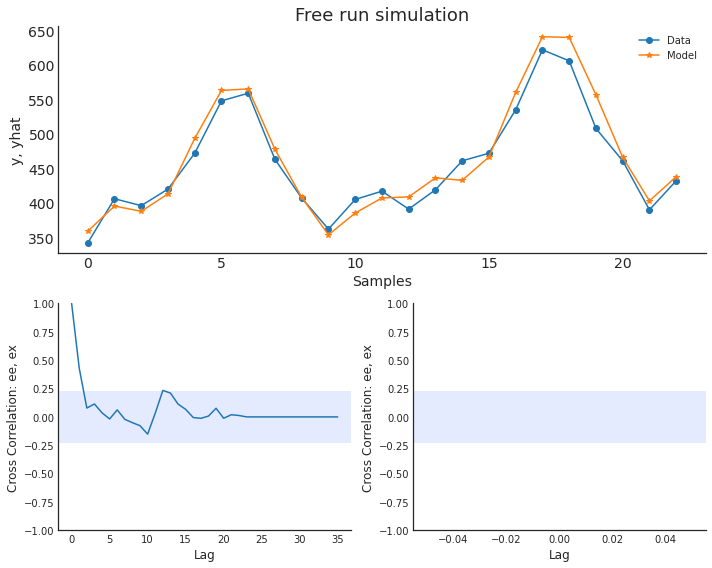

In [30]:
narx_net = NARXNN(
    net=NARX(),
    ylag=13,
    xlag=1,
    epochs=900,
    verbose=False,
    learning_rate=2.5E-02,
    optim_params={} # optional parameters of the optimizer
)

train_dl = narx_net.data_transform(x_train, y_train)
valid_dl = narx_net.data_transform(x_test, y_test)

narx_net.fit(train_dl, valid_dl)
yhat = narx_net.predict(x_test, y_test)
narxnet_loss = loss(pd.Series(y_test.flatten()[narx_net.max_lag:]), pd.Series(yhat.flatten()[narx_net.max_lag:]))
print(narxnet_loss)
ee, ex, extras, lam = narx_net.residuals(x_test, y_test, yhat)
narx_net.plot_result(y_test, yhat, ee, ex)